In [2]:
# Step 1: Load Data
words = open("../data/names.txt", "r").read().splitlines()

In [3]:
# Step 2: Inspect Data
print(words[:10])  

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia', 'harper', 'evelyn']


In [3]:
# Step 3: Count all letter pairs (bigrams)
b = {}

for w in words:
    chs = ["<S>"] + list(w) + ["<E>"]
    for ch1, ch2 in zip(chs, chs[1:]):
        bigram = (ch1, ch2)
        b[bigram] = b.get(bigram, 0) + 1

# b

In [4]:
# Step 4: Visualise Frequency Counts
import torch

chars = sorted(list(set("".join(words))))
stoi = {ch: i+1 for i, ch in enumerate(chars)}
stoi["."] = 0
itos = {i: ch for ch, i in stoi.items()}

# itos

In [5]:
# Step 5: Build Bigram Matrix
N = torch.zeros((27, 27), dtype=torch.int32)

for w in words:
    chs = ["."] + list(w) + ["."]
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        N[ix1, ix2] += 1

# N -> count how many times letter ix2 follows ix1

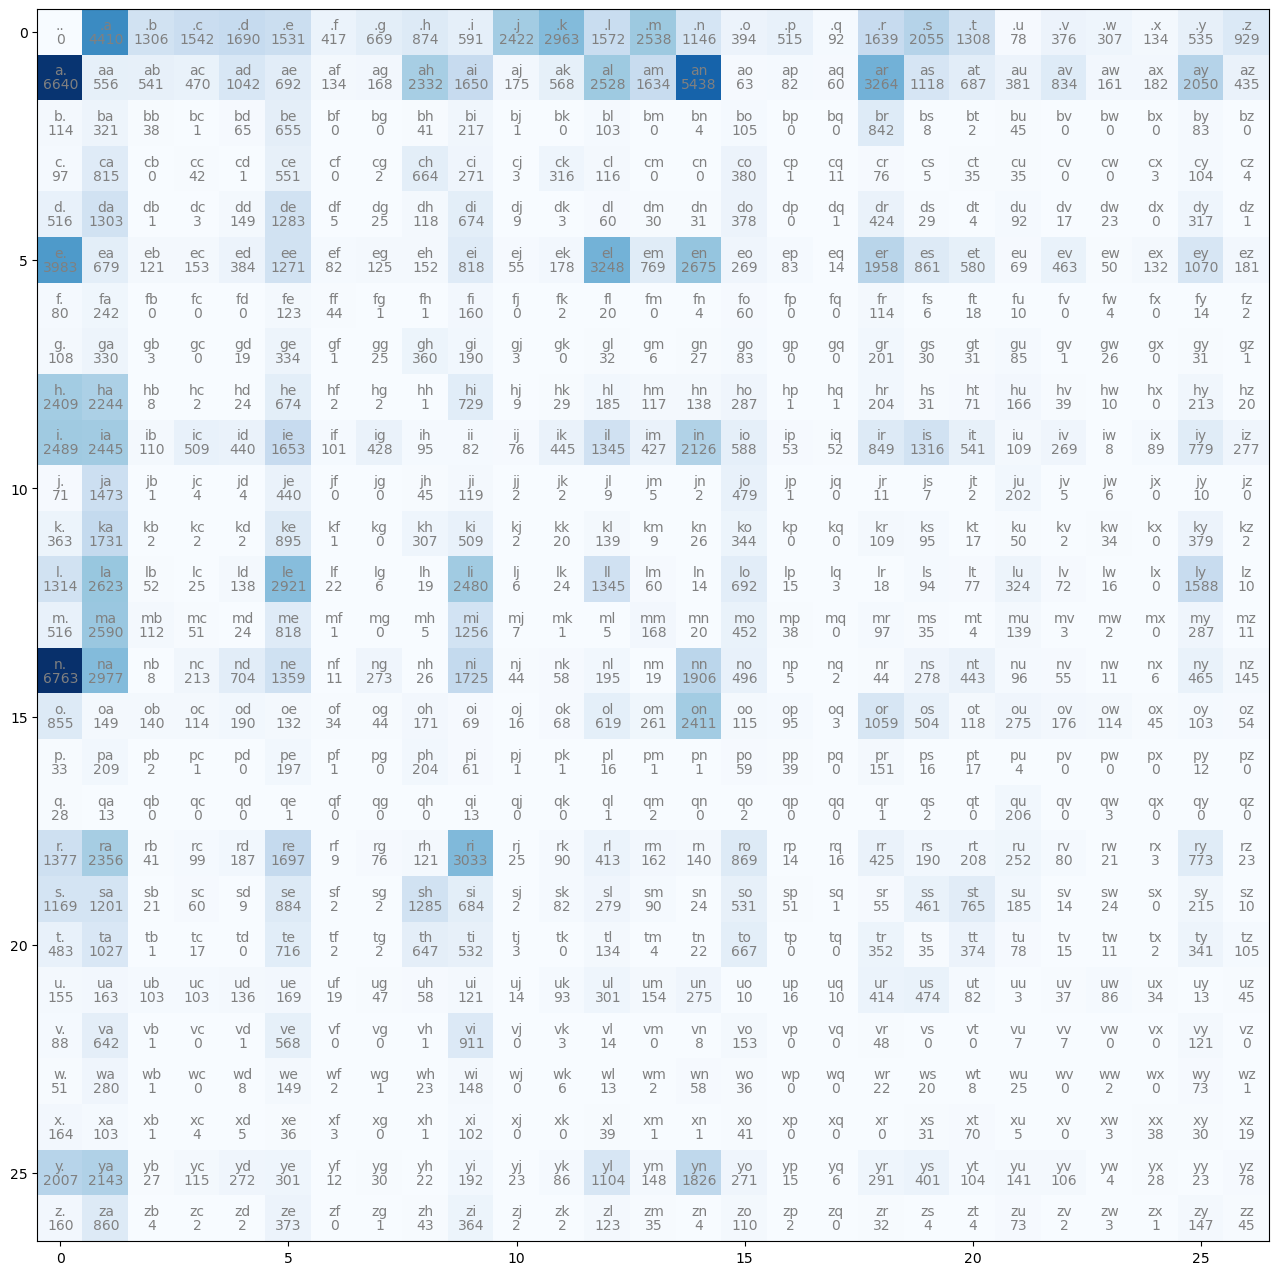

In [6]:
# Step 6: Visualise Data
import matplotlib.pyplot as plt
plt.figure(figsize=(16,16))
plt.imshow(N, cmap='Blues')
for i in range(27):
    for j in range(27):
        chstr = itos[i] + itos[j]
        plt.text(j, i, chstr, ha="center", va="bottom", color="gray")
        plt.text(j, i, N[i,j].item(), ha="center", va="top", color="gray")
plt.show()

In [7]:
# Step 7: Normalise into Probabilities
P = (N+1).float() # +1 -> Smoothening, so we dont get zero probabilities
P /= P.sum(1, keepdim=True)

# P

In [8]:
# Step 8: Check current generation of new names
g = torch.Generator().manual_seed(2147483647)

for i in range(50):
    out = []
    ix = 0
    while True:
        p = P[ix]
        ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
        out.append(itos[ix])
        if ix == 0:
            break
            
print("".join(out))

rddeman.


In [10]:
# Prepare training data
xs, ys = [], []

for w in words:
    chs = ["."] + list(w) + ["."]
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        xs.append(ix1)
        ys.append(ix2)

xs = torch.tensor(xs)
ys = torch.tensor(ys)
xs,ys

(tensor([ 0,  5, 13,  ..., 25, 26, 24]),
 tensor([ 5, 13, 13,  ..., 26, 24,  0]))

In [11]:
# Initialise Model Parameters
import torch.nn.functional as F

g = torch.Generator().manual_seed(2147483647)
W = torch.randn((27,27), generator=g, requires_grad=True)

In [14]:
# Forward pass
xenc = F.one_hot(xs, num_classes=27).float()
logits = xenc @ W # Matrix Multiply

# logits -> unnormalised scores (can be positive or negative) for each possible next letter

In [15]:
# Convert logits into probabilities (Apply Softmax Operation)
counts = logits.exp() # Exponentiate each number, make them positive
probs = counts / counts.sum(1, keepdim=True)

# Now probs[i, j] means:

# “Given input character xs[i], the probability of next character being itos[j].”

In [17]:
loss = -probs[torch.arange(xs.nelement()), ys].log().mean()
# loss -> Negative Log Likelihood Loss (NLL)

In [18]:
# Backward Pass (Gradient Calculation)
W.grad = None
loss.backward()
W.grad.shape, W.grad

(torch.Size([27, 27]),
 tensor([[ 8.5187e-03, -1.7928e-02, -3.9954e-03, -6.1678e-03, -5.0425e-03,
          -4.9856e-03, -1.4495e-03,  3.2138e-04, -1.9076e-03,  1.8004e-03,
          -9.5068e-03, -9.0844e-03, -5.6108e-03, -9.9720e-03,  1.9904e-03,
           3.1664e-02,  6.2140e-03, -5.3713e-05, -3.6864e-03, -8.2406e-03,
          -9.7538e-04,  1.1900e-03, -1.2434e-03,  1.4365e-03,  1.0683e-03,
           1.9233e-02,  1.6413e-02],
         [-2.6880e-02, -1.1534e-03,  3.5157e-03, -5.7258e-04,  4.4327e-03,
           1.5423e-03,  1.5517e-02,  1.2128e-03, -8.3641e-03, -6.5184e-03,
           1.4442e-02, -1.2133e-03,  3.5937e-03, -5.5054e-03, -2.0389e-02,
           2.7948e-03,  5.7026e-03,  8.9113e-04, -9.4967e-04,  2.9929e-03,
           3.8649e-03,  2.9188e-03, -2.8925e-03,  4.1746e-03,  8.9087e-03,
          -1.5171e-03, -5.5008e-04],
         [-2.1135e-04, -1.3155e-03,  1.9726e-04,  3.9496e-04, -1.8479e-04,
          -2.7573e-03,  2.8475e-04,  2.0133e-04, -9.1831e-05, -8.9764e-04,
   

In [19]:
# Update the weights (Gradient Descent)
W.data += -50 * W.grad

In [20]:
# Repeat Multiple times to train properly
for k in range(100):
    # Forward
    xenc = F.one_hot(xs, num_classes=27).float()
    logits = xenc @ W
    counts = logits.exp()
    probs = counts / counts.sum(1, keepdim=True)
    loss = -probs[torch.arange(xs.nelement()), ys].log().mean()

    # Backward
    W.grad = None
    loss.backward()

    # Update
    W.data += -50 * W.grad

print(loss.item())


2.4726526737213135


In [21]:
# In each iteration:

# - Compute predictions
# - Compute loss
# - Compute gradients
# - Update weights

# (repeat

# Each loop nudges W so that:

# “If I see letter X, I should predict letter Y with higher probability.”

In [23]:
# Try word generation now!
g = torch.Generator().manual_seed(2147483647)

for i in range(20):
    out = []
    ix = 0
    while True:
        logits = W[ix]
        counts = logits.exp()
        p = counts / counts.sum()
        ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
        out.append(itos[ix])
        if ix == 0:
            break
    print(''.join(out))

cexze.
momasurailezityha.
konimittain.
llayn.
ka.
da.
staiyauelalerigotai.
moliellavo.
ke.
teda.
ka.
emim.
sade.
enkaviyny.
fobspehinivenvtahlasu.
dsor.
br.
jol.
pyawaisan.
ja.
